# Lucid Data Scientist

In [1]:
# Importing packages Required 
from pyspark.context import SparkContext,SparkConf
from pyspark.sql import HiveContext,SQLContext
from pyspark.ml.feature import VectorAssembler , VectorIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Initializing Spark Context
spark = SparkSession.builder\
        .master("local[4]")\
        .appName("sql.functions tests")\
        .getOrCreate()
    
sc = spark.sparkContext

In [3]:
# Initializing Hive COntext 
sx = HiveContext(sc)
df = sx.read.parquet("/home/ratnam/Work/Lucid/dataset.parquet/dataset.parquet/")

In [4]:
df.createOrReplaceTempView("data")
spark.sql("select count(*) from data").show()

+--------+
|count(1)|
+--------+
| 6883958|
+--------+



In [5]:
import pyspark.sql.functions as fn 

df.agg(
    fn.count('f1').alias('RecordCount'),
    fn.countDistinct('label').alias('DistinctLabels')
).show()

+-----------+--------------+
|RecordCount|DistinctLabels|
+-----------+--------------+
|    6883958|             2|
+-----------+--------------+



In [6]:
ignore = ['label']
assembler = VectorAssembler(
    inputCols=[x for x in df.columns if x not in ignore],
    outputCol='features')

df = assembler.transform(df)

In [7]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df)

In [8]:
# Split the data into training and For Validation DataSet 
(Data, Validation) = df.randomSplit([0.9, 0.1] ,seed=521 )

In [9]:
# Validation Data Distribution
Validation.groupby('label').agg({'label': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|    1|          40|
|    0|      689362|
+-----+------------+



In [11]:
# Under Sampling of the Data as the Data is Biased 
class0 = Data.filter("label=0")
class1 = Data.filter("label=1")
Ratio =  class1.count() /float(Data.count())
class0df = class0.sample(False,Ratio*10,seed=124)
newdata = class1.unionAll(class0df)

In [12]:
# Balanced Data Distribution 
newdata.groupby('label').agg({'label': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|    1|         328|
|    0|        3268|
+-----+------------+



In [13]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = newdata.randomSplit([0.7, 0.3])

In [14]:
# Parameter
# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [15]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Saving the Predictions in the object
dxt = predictions.select("prediction" ,"indexedLabel").rdd

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         1.0|(502,[22,327,368,...|
|       0.0|         1.0|(502,[22,327,368,...|
|       0.0|         1.0|(502,[20,22,144,3...|
|       0.0|         1.0|(502,[20,22,327,3...|
|       1.0|         1.0|(502,[3,4,5,20,21...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.0588235
GBTClassificationModel (uid=GBTClassifier_4733937db3740df4861d) with 10 trees


In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Area Under ROC is ", evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))

Area Under ROC is  0.9191985332634887


In [17]:
# Calculating the F1 Score 
metrics = MulticlassMetrics(dxt)
print("F1 Score for the Model is",metrics.fMeasure())

F1 Score for the Model is 0.9411764705882353


In [18]:
Validation_predictions = model.transform(Validation)
val_pred = Validation_predictions.select("prediction" ,"indexedLabel").rdd

In [19]:
Validation_predictions.select("prediction" ,"indexedLabel").show(2)

+----------+------------+
|prediction|indexedLabel|
+----------+------------+
|       0.0|         0.0|
|       0.0|         0.0|
+----------+------------+
only showing top 2 rows



In [20]:
# Calculating the F1 Score 
val_metrics = MulticlassMetrics(val_pred)
print("F1 Score for the Model is",val_metrics.fMeasure())

F1 Score for the Model is 0.9849289674239413


In [21]:
tp = Validation_predictions[(Validation_predictions.indexedLabel == 1) & (Validation_predictions.prediction == 1)].count()
tn = Validation_predictions[(Validation_predictions.indexedLabel == 0) & (Validation_predictions.prediction == 0)].count()
fp = Validation_predictions[(Validation_predictions.indexedLabel == 0) & (Validation_predictions.prediction == 1)].count()
fn = Validation_predictions[(Validation_predictions.indexedLabel == 1) & (Validation_predictions.prediction == 0)].count()

In [22]:
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)

True Positives: 20
True Negatives: 678992
False Positives: 10370
False Negatives: 20


In [23]:
#gbtModel.featureImportances
importances = gbtModel.featureImportances
indices = np.argsort(importances)

In [24]:
import pandas as pd
data=(importances.values,importances.indices) 

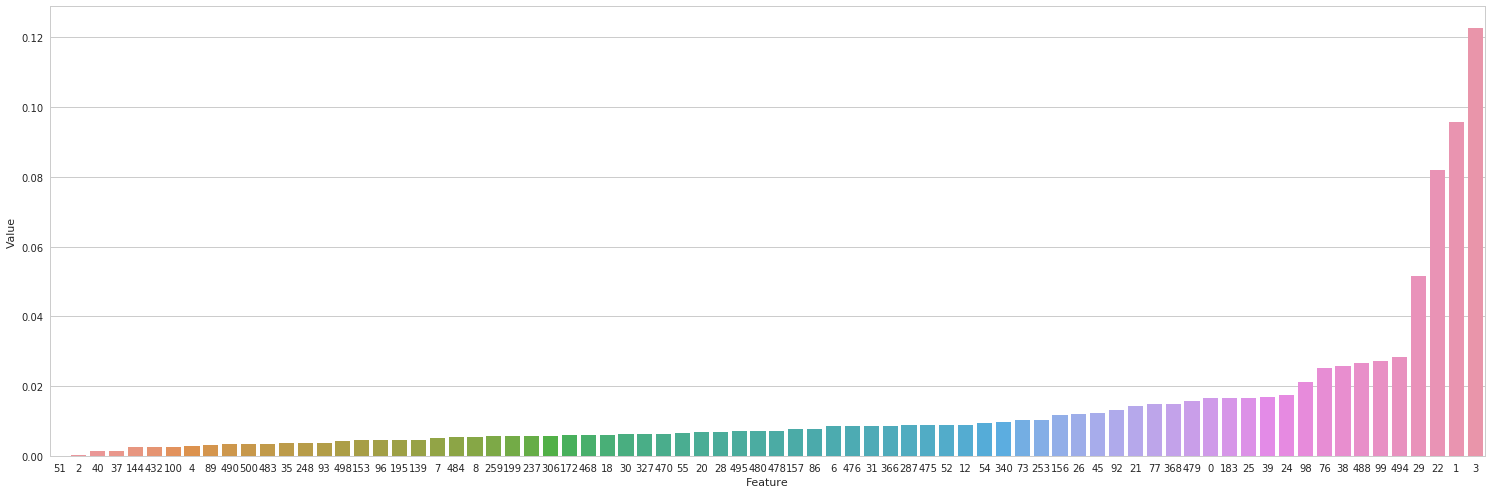

In [25]:
x = pd.DataFrame(data[1], data[0]).reset_index()
x.columns = ['Value', 'Feature']
x = x.sort_values(['Value'])
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
fig, ax = plt.subplots()
fig.set_size_inches(25.7, 8.27)
sns.barplot(x['Feature'] ,x['Value'] ,order=x['Feature'])

In [26]:
spark.stop()